# Time Series Clustering

In [105]:
library(zoo)
library(imputeTS)
library(TSclust)
library(ggplot2)
library(reshape)
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 3.6.3"


In [ ]:
CLUSTERING_DISTANCES <- c("euclidean", "maximum", "manhattan", "canberra", "binary", "minkowski")

RAWDATA_BASED <- c("DTWARP", "FRECHET", "EUCL")
AUTOCORRELATION_BASED <- c("ACF", "PACF")
CORRELATION_BASED <- c("COR")
PROXIMITYVALUE_BASED <- c("CORT")
PERIODOGRAM_BASED <- c("PER", "INT.PER")
SPECTRAL_BASED <- c("SPEC.LLR", "SPEC.GLK", "SPEC.ISD")
MODEL_BASED <- c("AR.MAH", "AR.PIC", "AR.LPC.CEPS")
COMPLEXITY_BASED <- c("PDC","CDM","CID", "NCD")
SYMBOLIC_BASED <- c("MINDIST.SAX")
PREDICTION_BASED <- c("PRED")
WAVELET_BASED <- c("DWT")
TS_CLUST_DISTANCES <- c(RAWDATA_BASED,
                        AUTOCORRELATION_BASED,
                        CORRELATION_BASED,
                        PROXIMITYVALUE_BASED,
                        PERIODOGRAM_BASED,
                        SPECTRAL_BASED,
                        MODEL_BASED,
                        COMPLEXITY_BASED,
                        SYMBOLIC_BASED,
                        PREDICTION_BASED,
                        WAVELET_BASED)


## Auxiliary functions

Basic growth rate $r(t) = \frac{x(t+1)}{x(t)}$

In [ ]:
growthRate <- function(ts){
    # x(t) = head(x,-1)
    # x(t+1) = tail(x,-1)
    return(c(NaN,tail(ts,-1)/head(ts,-1)))
}

Normalized growth rate $r_N(t) = \frac{x(t+1)-x(t)}{x(t)}$

In [ ]:
growthRateNormalized <- function(ts){
    # x(t) = head(x,-1)
    # x(t+1) = tail(x,-1)
    return(c(NaN,(tail(ts,-1)-head(ts,-1))/head(ts,-1)))
}


In [5]:
splitData <- function(province_country_pair,data.df){
    data.df[data.df$Country.Region == province_country_pair[1]&
            data.df$Province.State == province_country_pair[2] 
            ,]
}

computeGrowthRate <- function(country.df,growth_rate_function){
    country.df$ConfirmedGrowthRate <- growth_rate_function(country.df$Confirmed)
    country.df$RecoveredGrowthRate <- growth_rate_function(country.df$Recovered)
    country.df$DeathsGrowthRate <- growth_rate_function(country.df$Deaths)
    return(country.df)
}


In [ ]:
compareClusteringDistances <- function(data,true_data_clusters){
    true_clusters <- length(levels(true_data_clusters))
    results_df <- data.frame(Distance=character(),Concordance=numeric(),Time=numeric())
    
    for(distance in CLUSTERING_DISTANCES){
        print(paste("[INFO] - Testing",distance))
        ptm <- proc.time()
        distance_matrix <- dist(data, method = distance) # distance matrix
        time_cluster <- proc.time() - ptm
        fit <- hclust(distance_matrix, method="ward")
        groups <- cutree(fit, k=true_clusters)
        results_df <- bind_rows(results_df,
                                   data.frame(Distance=distance,
                                              Concordance=sum(as.numeric(true_data_cluster) == groups)/N),
                                              Time=time_cluster[3])
    }
    return(results_df)
}

computeTSClusteringDistances <- function(data,distances_vector,dataset_name){
  results_df <- data.frame(Distance=character(),Columns=numeric(),Time=numeric())
  
  for(distance in distances_vector){
    print(paste("[INFO] - Computing",distance))
    ptm <- proc.time()
    distance_matrix <- diss(data.frame(data),distance) # distance matrix
    time_cluster <- proc.time() - ptm
    print(paste("[INFO] - Distance matrix shape:",dim(distance_matrix)))
    saveRDS(distance_matrix,paste("DFML_",dataset_name,distance,"dm.Rdata",sep="_"))
    results_df <- bind_rows(results_df,
                            data.frame(Distance=distance,
                                       Columns=ncol(data),
                                       Time=time_cluster[3]))
    
  }
  return(results_df)
}


## Read data in

In [18]:
data.df <- readRDS("data/COVID19_Global_Italy_wGrowth.Rdata")

In [ ]:
head(data.df)

## Split data accoring to unique Country-Province Pair

In [19]:
unique_pairs.df <- unique(data.df[,c("Country.Region","Province.State")])
unique_pairs.list <- mapply(c,unique_pairs.df$Country.Region,as.character(unique_pairs.df$Province.State), SIMPLIFY = FALSE)

In [20]:
split_data.list <- lapply(unique_pairs.list,splitData,data.df)

In [8]:
head(split_data.list[[1]])

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,...,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,,Afghanistan,33,65,2020-01-22,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
23,,Afghanistan,33,65,2020-01-23,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
24,,Afghanistan,33,65,2020-01-24,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
25,,Afghanistan,33,65,2020-01-25,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
26,,Afghanistan,33,65,2020-01-26,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
27,,Afghanistan,33,65,2020-01-27,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN


## Create a multivariate time series dataset

In [21]:
confirmed_ts.list <- lapply(split_data.list,function(data.df){zoo(data.df[,c("Confirmed")],order.by=as.Date(data.df$Date))})
confirmed_ts.zoo <- Reduce(merge,confirmed_ts.list)
colnames(confirmed_ts.zoo) <- lapply(unique_pairs.list,paste,collapse="_")

In [22]:
dim(confirmed_ts.zoo)

[1]  67 256

In [23]:
head(confirmed_ts.zoo)

           Afghanistan_ Albania_ Algeria_ Andorra_ Angola_ Antigua and Barbuda_
2020-01-22            0        0        0        0       0                    0
2020-01-23            0        0        0        0       0                    0
2020-01-24            0        0        0        0       0                    0
2020-01-25            0        0        0        0       0                    0
2020-01-26            0        0        0        0       0                    0
2020-01-27            0        0        0        0       0                    0
           Argentina_ Armenia_ Australia_Australian Capital Territory
2020-01-22          0        0                                      0
2020-01-23          0        0                                      0
2020-01-24          0        0                                      0
2020-01-25          0        0                                      0
2020-01-26          0        0                                      0
2020-01-27          

## Explore data

In [35]:
confirmed_ts.zoo[,grepl("Italy|China",colnames(confirmed_ts.zoo))]

           China_Anhui China_Beijing China_Chongqing China_Fujian China_Gansu
2020-01-22           1            14               6            1           0
2020-01-23           9            22               9            5           2
2020-01-24          15            36              27           10           2
2020-01-25          39            41              57           18           4
2020-01-26          60            68              75           35           7
2020-01-27          70            80             110           59          14
2020-01-28         106            91             132           80          19
2020-01-29         152           111             147           84          24
2020-01-30         200           114             182          101          26
2020-01-31         237           139             211          120          29
2020-02-01         297           168             247          144          40
2020-02-02         340           191             300          15

In [16]:
data.df[data.df$Province.State == "Lombardia",]

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,...,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,Lombardia,Italy,45.46679,9.190347,2020-03-27,23895,8001,5402,11137,1292,...,1706,37298,95860,NA,NA,NA,NA,NaN,NaN,NaN


## Clustering all the variables

In [ ]:
distance <- "ACF"
nations_with_missing_values <- which( apply(is.na(confirmed_ts.zoo),2,sum) > 33, arr.ind = T)

### Imputing missing values

In [69]:
confirmed_ts_imputed.zoo <- apply(confirmed_ts.zoo[,-c(nations_with_missing_values)],2,na.interpolation)

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

### Computing distance matrix

In [ ]:
confirmed_distance_matrix <- diss(data.frame(confirmed_ts_imputed.zoo),distance) # distance matrix
confirmed_distance_matrix[is.na(confirmed_distance_matrix)] <- max(confirmed_distance_matrix,na.rm = T) + 1
ggplot(melt(as.matrix(confirmed_distance_matrix))) +
    geom_tile(aes(x=X1,y=X2,color=value))

### Performing hierarchical clustering

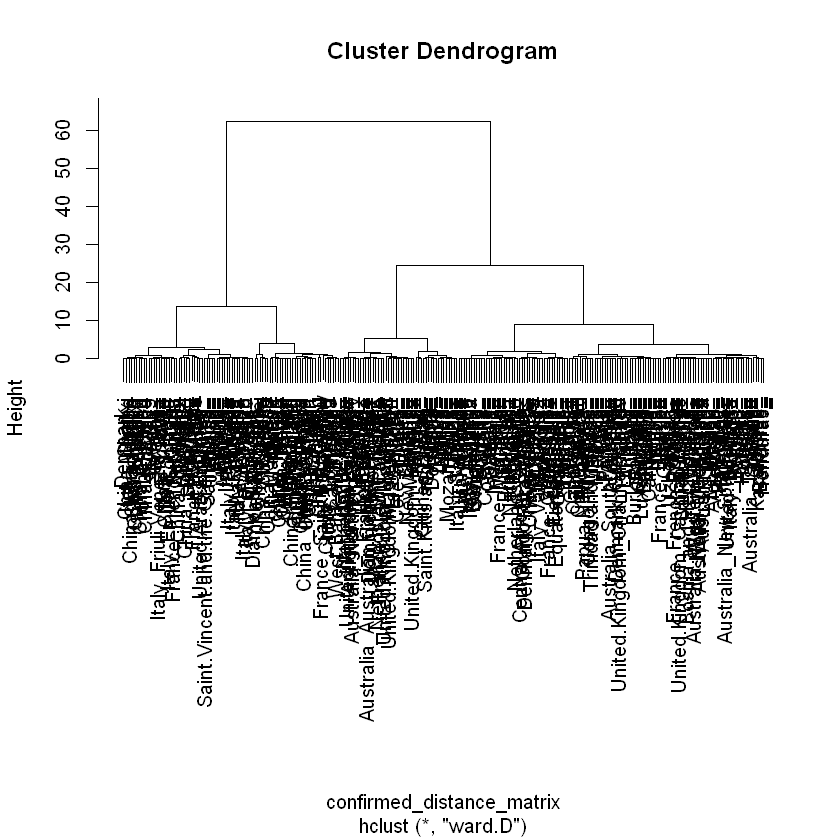

In [58]:
confirmed_hclust <- hclust(confirmed_distance_matrix, method="ward.D")
plot(confirmed_hclust)

## Clustering only selected variables and pre-post analysis

### Filter only required columns

In [59]:
selected_confirmed_ts.zoo <- confirmed_ts.zoo[,-c(nations_with_missing_values)]
selected_confirmed_ts.zoo <- selected_confirmed_ts.zoo[,grepl("Italy|USA",colnames(selected_confirmed_ts.zoo))]


Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

### Impute missing data

In [76]:
selected_confirmed_ts_imputed.zoo <- apply(selected_confirmed_ts.zoo,2,na.interpolation)

Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by na_interpolation.
           Functionality stays the same.
           The new function name better fits modern R code style guidelines.
           Please adjust your code accordingly."
Warning message:
"na.interpolation will replaced by 

### Split data into pre-lockdown and post lockdown

In [99]:
splitting_index <- which(rownames(selected_confirmed_ts_imputed.zoo) == as.Date("2020-03-10"),arr.ind=T)

In [101]:
pre_lockdown_imputed.zoo <- selected_confirmed_ts_imputed.zoo[1:splitting_index,]
post_lockdown_imputed.zoo <- selected_confirmed_ts_imputed.zoo[splitting_index:nrow(selected_confirmed_ts_imputed.zoo),]

### Computing distance matrices

In [106]:
pre_lockdown_dm <- diss(data.frame(pre_lockdown_imputed.zoo),distance) # distance matrix
pre_lockdown_dm[is.na(pre_lockdown_dm)] <- max(pre_lockdown_dm,na.rm = T) + 1

In [107]:
post_lockdown_dm <- diss(data.frame(post_lockdown_imputed.zoo),distance) # distance matrix
post_lockdown_dm[is.na(post_lockdown_dm)] <- max(post_lockdown_dm,na.rm = T) + 1

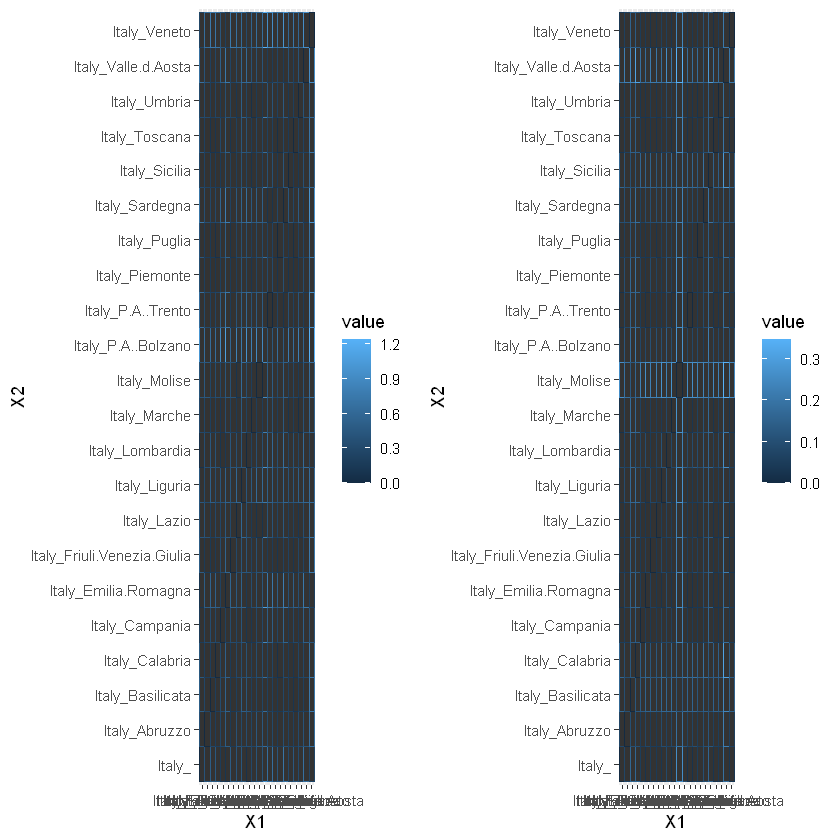

In [108]:
pre_dm.plot <- ggplot(melt(as.matrix(pre_lockdown_dm),value.name = value)) +
    geom_tile(aes(x=X1,y=X2,color=value))
post_dm.plot <- ggplot(melt(as.matrix(post_lockdown_dm),value.name = value)) +
    geom_tile(aes(x=X1,y=X2,color=value))
grid.arrange(pre_dm.plot, post_dm.plot, ncol=2)


In [110]:
pre_hclust <- hclust(pre_lockdown_dm, method="ward.D")

In [111]:
post_hclust <- hclust(post_lockdown_dm, method="ward.D")

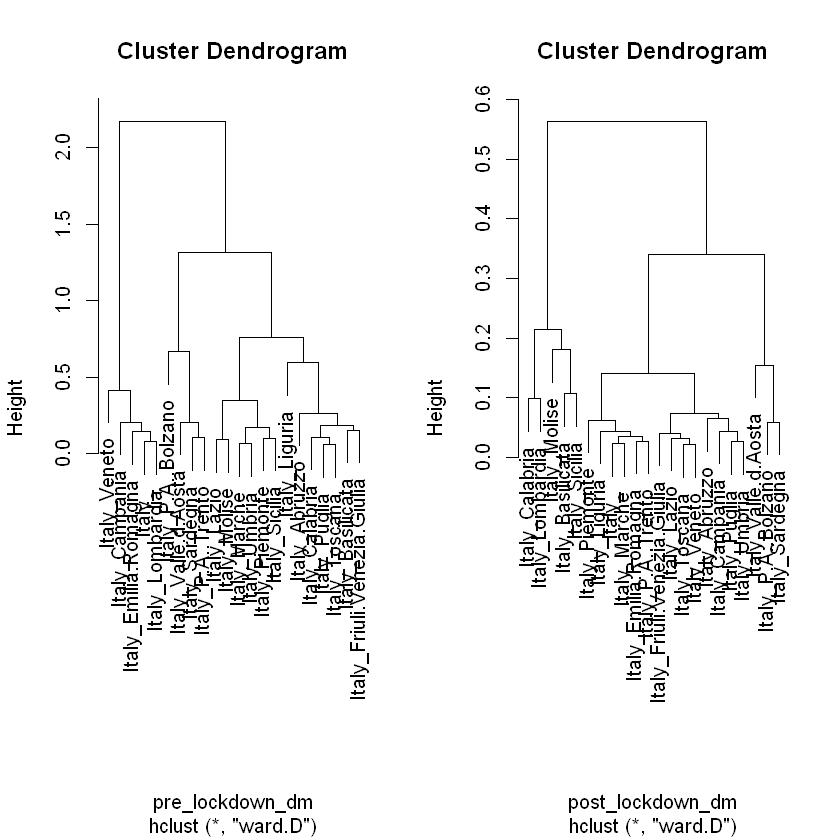

In [113]:
par(mfrow=c(1,2))
plot(pre_hclust)
plot(post_hclust)


## Sanity checks

## Save data